# This Notebook is for Tuning Star-Galaxy Separation
- Take MGC as "truth" and compare number of detected galaxies in a region compared to current galaxy detection pipeline
- Tune pipeline parameters to get as many correct galaxies as possbile
- A galaxy from each catalog will be considered a "match" if they are within a small distance of each other.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

# from astropy.table import Table
# from PIL import Image
# from io import BytesIO
# import requests

import redshiftpredictor as rp
import astroFuncs as af

/home/richard/miniconda3/envs/astroWork/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
def get_mgc_data(filepath):
    #reading in the bright catalog and the clean faint catalog
    mgc_bright = pd.read_csv(filepath+"mgc_bright.txt",
    names=["ID","MGCFN","X_IMAGE","Y_IMAGE","MAG_ISO","MAG_ISO_DC","MAG_ISOCOR",
           "MAG_ISOCOR_DC","MAG_AUTO","MAG_AUTO_DC","B_MGC","B_MGC_DC","MAG_ERR",
           "BACKGRND","THRESH","ISOAREA_IMAGE","ALPHA_J2000","DELTA_J2000",
           "ALPHA_B1950","DELTA_B1950","A_IMAGE","B_IMAGE","THETA_IMAGE",
           "ERRA_IMAGE","ERRB_IMAGE","ISOAREA_WORLD","FLAGS","FWHM_IMAGE",
           "ELLIPTICITY","STEL","CCD","CLASS","QUALITY","HLRADIUS","INEXR"],
    delimiter=" ")
    
    mgc_faint = pd.read_csv(filepath+"mgc_faint.txt",
            names=["ID","MGCFN","X_IMAGE","Y_IMAGE","MAG_ISO","MAG_ISO_DC","MAG_ISOCOR",
           "MAG_ISOCOR_DC","MAG_AUTO","MAG_AUTO_DC","B_MGC","B_MGC_DC","MAG_ERR",
           "BACKGRND","THRESH","ISOAREA_IMAGE","ALPHA_J2000","DELTA_J2000",
           "ALPHA_B1950","DELTA_B1950","A_IMAGE","B_IMAGE","THETA_IMAGE",
           "ERRA_IMAGE","ERRB_IMAGE","ISOAREA_WORLD","FLAGS","FWHM_IMAGE",
           "ELLIPTICITY","STEL","CCD","CLASS"],
            delimiter=" ",
            on_bad_lines="skip") #skipping bad lines as there are abt 50 lines with a " " at the start making them hard to read
    #combine catalogs
    mgc_all = pd.concat([mgc_bright, mgc_faint])
    #return
    return mgc_all

### reading in data

In [5]:
filepath="/home/richard/Work/placement_project/CNGFPPR/data/"

In [6]:
mgc_bright = pd.read_csv(filepath+"mgc_bright.txt",
            names=["ID","MGCFN","X_IMAGE","Y_IMAGE","MAG_ISO","MAG_ISO_DC","MAG_ISOCOR",
           "MAG_ISOCOR_DC","MAG_AUTO","MAG_AUTO_DC","B_MGC","B_MGC_DC","MAG_ERR",
           "BACKGRND","THRESH","ISOAREA_IMAGE","ALPHA_J2000","DELTA_J2000",
           "ALPHA_B1950","DELTA_B1950","A_IMAGE","B_IMAGE","THETA_IMAGE",
           "ERRA_IMAGE","ERRB_IMAGE","ISOAREA_WORLD","FLAGS","FWHM_IMAGE",
           "ELLIPTICITY","STEL","CCD","CLASS","QUALITY","HLRADIUS","INEXR"],
            delimiter=" ")



In [7]:
mgc_faint = pd.read_csv(filepath+"mgc_faint.txt",
            names=["ID","MGCFN","X_IMAGE","Y_IMAGE","MAG_ISO","MAG_ISO_DC","MAG_ISOCOR",
           "MAG_ISOCOR_DC","MAG_AUTO","MAG_AUTO_DC","B_MGC","B_MGC_DC","MAG_ERR",
           "BACKGRND","THRESH","ISOAREA_IMAGE","ALPHA_J2000","DELTA_J2000",
           "ALPHA_B1950","DELTA_B1950","A_IMAGE","B_IMAGE","THETA_IMAGE",
           "ERRA_IMAGE","ERRB_IMAGE","ISOAREA_WORLD","FLAGS","FWHM_IMAGE",
           "ELLIPTICITY","STEL","CCD","CLASS"],
            delimiter=" ",
            on_bad_lines="skip") #skipping bad lines as there are abt 50 lines with a " " at the start making them hard to read


In [8]:
mgc_zcat = pd.read_csv(filepath+"mgc_zcat.txt",
            delim_whitespace=True,
            names=["ID", "MGCFN", "ALPHA_J2000", "DELTA_J2000", "QUALITY", "CLASS", "INEXR",
                   "SDSS_OBJID", "SDSS_PSFMAG_G", "SDSS_PSFMAG_R", "SDSS_PSFMAG_I", "SDSS_PSFMAG_Z",
                   "SDSS_PETMAG_G", "SDSS_PETMAG_R", "SDSS_PETMAG_I", "SDSS_PETMAG_Z",
                   "BEST_Z", "BEST_ZQUAL"],
            usecols=[0, 1, 5, 6, 16, 18, 19, 21, 29, 30, 31, 32, 34, 35, 36, 37, 121, 122],
            on_bad_lines="skip")

In [7]:
mgc_zcat

ID  MGCFN  ALPHA_J2000  DELTA_J2000  QUALITY  CLASS  INEXR  \
0        247      1    149.91002     -0.09931        0      8      1   
1        249      1    149.83809     -0.09963        1      1      1   
2        250      1    149.83315     -0.10093        0      8      0   
3        253      1    149.85988     -0.10463        0      8      0   
4        254      1    150.13480     -0.10935        0      8      0   
...      ...    ...          ...          ...      ...    ...    ...   
69589  68777    144    221.56970      0.00191        0      8      0   
69590  68778    144    221.39485      0.00349        0      8      0   
69591  95535    144    221.37004      0.07297        0      8      0   
69592  95857    144    221.50311     -0.01128        0      8      0   
69593  95860    144    221.38013      0.06924        0      8      0   

               SDSS_OBJID  SDSS_PSFMAG_G  SDSS_PSFMAG_R  SDSS_PSFMAG_I  \
0      582093500458467470         19.035         17.642         16.538   
1      582093500458402045         19.704         18.589         18.159   
2      582093500458401862         16.772         15.968         15.688   
3      582093500458401876         17.974         17.460         17.285   
4      582093500458533093         19.568         19.060         18.872   
...                   ...            ...            ...            ...   
69589  582093483834671353         18.409         16.950         15.955   
69590  582093483834605653         17.852         17.280         17.026   
69591  582093483834605631         19.689         18.361         17.501   
69592  582093500489793603         15.816         15.442         15.299   
69593  582093483834605633         20.074         19.850         19.727   

       SDSS_PSFMAG_Z  SDSS_PETMAG_G  SDSS_PETMAG_R  SDSS_PETMAG_I  \
0             15.968         19.089         17.707         16.608   
1             17.943         18.781         17.619         17.159   
2             15.588         16.835         16.013         15.738   
3             17.259         18.086         17.542         17.379   
4             18.848         19.644         19.109         18.914   
...              ...            ...            ...            ...   
69589         15.416         18.472         17.004         16.015   
69590         16.943         17.894         17.304         17.086   
69591         17.061         19.752         18.415         17.576   
69592         15.273         15.834         15.483         15.351   
69593         19.693         20.114         19.898         19.778   

       SDSS_PETMAG_Z   BEST_Z  BEST_ZQUAL  
0             16.012  9.99999           9  
1             16.874  0.16819           4  
2             15.615  9.99999           9  
3             17.343  9.99999           9  
4             18.871  9.99999           9  
...              ...      ...         ...  
69589         15.492  9.99999           9  
69590         17.003  9.99999           9  
69591         17.111  9.99999           9  
69592         15.334  9.99999           9  
69593         19.674  9.99999           9  

[69594 rows x 18 columns]

Happy to use only galaxy classification as the classifications look accurate

In [8]:
mgc_bright = mgc_bright.query("CLASS==1 and INEXR==0 and QUALITY<=2") #these conditions reccomended for clean "bright" catalogue

mgc_faint = mgc_faint.query("CLASS==1")

In [9]:
#combine catalogs
mgc_all = pd.concat([mgc_bright, mgc_faint]).reset_index(drop=True)

In [10]:
mgc_all

ID  MGCFN  X_IMAGE   Y_IMAGE  MAG_ISO  MAG_ISO_DC  MAG_ISOCOR  \
0             9      1  999.001  1646.936  18.2599   18.148440     18.2165   
1            25      1  755.615  1755.004  19.4206   19.311424     19.3065   
2            29      1  616.778  2433.785  19.5026   19.396427     19.4449   
3            31      1  601.533  3640.720  19.9964   19.891031     19.9241   
4            32      1  597.813  3514.283  19.9165   19.811130     19.8747   
...         ...    ...      ...       ...      ...         ...         ...   
367841  1479289    144  987.883  3867.036  22.7899   22.623068     22.4805   
367842  1479296    144  990.685  3077.303  23.6031   23.435127     23.1586   
367843  1479304    144  995.167  2371.529  23.0566   22.888966     22.7685   
367844  1479314    144  998.612  3121.208  21.3128   21.144827     21.1983   
367845  1479315    144  998.831  2752.773  23.0292   22.859873     22.6412   

        MAG_ISOCOR_DC  MAG_AUTO  MAG_AUTO_DC  ...  ISOAREA_WORLD  FLAGS  \
0           18.105040   18.2358    18.124340  ...   1.172190e-05      0   
1           19.197323   19.3139    19.204723  ...   7.033120e-06      2   
2           19.338728   19.4548    19.348627  ...   4.520690e-06      2   
3           19.818731   19.9153    19.809930  ...   3.327500e-06      0   
4           19.769331   19.9062    19.800830  ...   2.445210e-06      0   
...               ...       ...          ...  ...            ...    ...   
367841      22.313667   22.7865    22.619669  ...   5.545830e-07      3   
367842      22.990627   22.9948    22.826828  ...   3.361110e-07      0   
367843      22.600864   22.9482    22.780565  ...   3.865280e-07      2   
367844      21.030327   21.2856    21.117628  ...   1.352850e-06      0   
367845      22.471872   23.1314    22.962072  ...   3.193060e-07      2   

        FWHM_IMAGE  ELLIPTICITY  STEL  CCD  CLASS  QUALITY  HLRADIUS  INEXR  
0             6.37        0.176  0.03    3      1      1.0     8.910    0.0  
1             6.04        0.063  0.03    3      1      1.0     6.810    0.0  
2             6.30        0.121  0.03    3      1      1.0     4.825    0.0  
3             5.49        0.128  0.03    3      1      1.0     4.840    0.0  
4            11.49        0.378  0.03    3      1      1.0     5.560    0.0  
...            ...          ...   ...  ...    ...      ...       ...    ...  
367841       14.60        0.213  0.06    4      1      NaN       NaN    NaN  
367842       11.47        0.253  0.27    4      1      NaN       NaN    NaN  
367843       10.21        0.115  0.61    4      1      NaN       NaN    NaN  
367844        9.91        0.099  0.02    4      1      NaN       NaN    NaN  
367845        8.50        0.330  0.56    4      1      NaN       NaN    NaN  

[367846 rows x 35 columns]

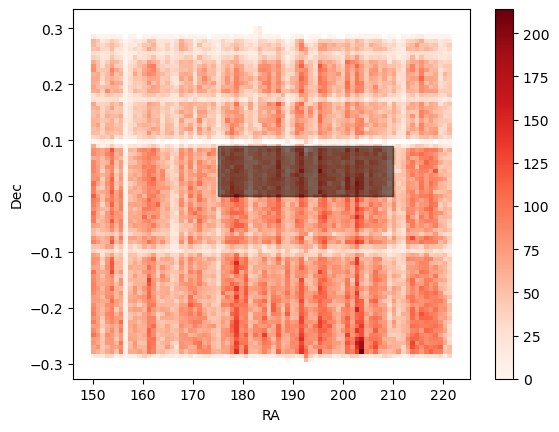

In [11]:
fig, axs = plt.subplots()

sns.histplot(x=mgc_all[mgc_all['CLASS']==1].ALPHA_J2000, y=mgc_all[mgc_all['CLASS']==1].DELTA_J2000, cbar=True, cmap="Reds", ax=axs)

plt.xlabel("RA")
plt.ylabel("Dec")

rect = patches.Rectangle((175,0), 35, 0.09, linewidth=1, edgecolor='k', facecolor="k", alpha=0.5)
axs.add_patch(rect)

plt.show()

In [12]:
mgc = mgc_all.query("ALPHA_J2000 > 175 & ALPHA_J2000 < 205 &\
                        DELTA_J2000 > 0 & DELTA_J2000 < 0.09&\
                        MAG_AUTO < 20")

In [13]:
mgc

ID  MGCFN    X_IMAGE     Y_IMAGE  MAG_ISO  MAG_ISO_DC  \
3656      23404     51   868.4950   840.34000  19.6732   19.558653   
3691      23608     52   216.4100   914.99600  20.0353   19.935724   
3710      23751     52   396.9580  3749.67100  19.9916   19.876840   
3712      23778     52   500.1792   409.76202  17.8788   17.763447   
3713      23780     52   907.1821   434.10601  18.9823   18.868385   
...         ...    ...        ...         ...      ...         ...   
9996      96288    101  1183.4600   393.40000  19.8744   19.770500   
10089     97071     74   430.5700  3483.71000  19.7268   19.616400   
141599    95505     59   567.1000  2139.73000  20.5831   20.478100   
266802    95607    105  1379.4300   967.34000  20.5261   20.420000   
284202  1164435    109   882.6460  1301.71100  20.2154   20.103390   

        MAG_ISOCOR  MAG_ISOCOR_DC  MAG_AUTO  MAG_AUTO_DC  ...  ISOAREA_WORLD  \
3656       19.6105      19.495953   19.6389    19.524353  ...       0.000004   
3691       19.9310      19.831425   19.9866    19.887026  ...       0.000004   
3710       19.9297      19.814941   19.9847    19.869940  ...       0.000003   
3712       17.8435      17.728148   17.8777    17.762348  ...       0.000014   
3713       18.9566      18.842686   18.9894    18.875486  ...       0.000004   
...            ...            ...       ...          ...  ...            ...   
9996       19.8744      19.770500   19.8744    19.770500  ...       0.000001   
10089      19.6867      19.576300   19.7225    19.612100  ...       0.000003   
141599     20.2690      20.164000   19.7940    19.689000  ...       0.000004   
266802     20.3996      20.293500   19.9709    19.864800  ...       0.000003   
284202     20.1812      20.069190   19.8461    19.734089  ...       0.000002   

        FLAGS  FWHM_IMAGE  ELLIPTICITY  STEL  CCD  CLASS  QUALITY  HLRADIUS  \
3656        0       14.81        0.492  0.03    4      1      1.0     7.870   
3691        3       26.27        0.572  0.03    4      1      1.0    10.480   
3710        0        7.15        0.069  0.04    4      1      1.0     4.450   
3712        0       13.80        0.070  0.03    2      1      1.0     9.420   
3713        0        8.89        0.131  0.03    2      1      1.0     4.910   
...       ...         ...          ...   ...  ...    ...      ...       ...   
9996        0        6.28        0.061  0.00    2      1      2.0     6.405   
10089       3        7.98        0.376  0.03    4      1      1.0     4.952   
141599      3       31.76        0.457  0.00    4      1      NaN       NaN   
266802      3        8.36        0.552  0.03    2      1      NaN       NaN   
284202      3       10.63        0.471  0.03    4      1      NaN       NaN   

        INEXR  
3656      0.0  
3691      0.0  
3710      0.0  
3712      0.0  
3713      0.0  
...       ...  
9996      0.0  
10089     0.0  
141599    NaN  
266802    NaN  
284202    NaN  

[627 rows x 35 columns]

In [14]:
mgc_zcat_roi = mgc_zcat.query("ALPHA_J2000 > 175 & ALPHA_J2000 < 205 &\
                        DELTA_J2000 > 0 & DELTA_J2000 < 0.09")

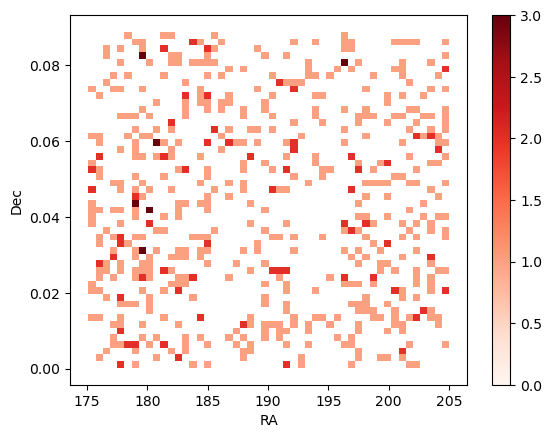

In [15]:
sns.histplot(x=mgc.ALPHA_J2000, y=mgc.DELTA_J2000, cbar=True, cmap="Reds", bins=50)

plt.xlabel("RA")
plt.ylabel("Dec")

plt.show()

Over this 2.7 degree area get all PS1 Sources

In [16]:
ra1, ra2 = 175, 205
dec1, dec2 = 0, 0.09

In [17]:
already_have_ps1_table = True

In [18]:
af.mastcasjobs_init()

if already_have_ps1_table == True:
    table_name = "PS1_MGC_PipelineTest"
    ps1 = af.retrieve_table(table_name)
else:
    ps1 = af.search_rect_region(ra1, ra2, dec1, dec2,
                            table_name="PS1_MGC_PipelineTest", task_name="PS1_MGC_PipelineTest")

Enter Casjobs username: richardon
Enter Casjobs password: ········


In [19]:
ps1

objID      raMean   decMean    gKronMag    gPSFMag  \
0       108001750033284714  175.003327  0.003568 -999.000000  24.133699   
1       108001750055231735  175.005523  0.001097 -999.000000  25.642900   
2       108001750055288763  175.005652  0.006942 -999.000000  23.534700   
3       108001750077218997  175.007698  0.007089   22.835501  23.170799   
4       108001750077789873  175.007798  0.007871 -999.000000  25.513201   
...                    ...         ...       ...         ...        ...   
134477  108102049871292387  204.987174  0.084993   22.438700  22.590700   
134478  108102049881207965  204.988121  0.089610 -999.000000  23.597300   
134479  108102049918601892  204.991848  0.084550   23.183001  23.508200   
134480  108102049968823345  204.996845  0.085715 -999.000000  23.130301   
134481  108102049985137053  204.998485  0.088797   21.723600  21.814501   

        gKronMagErr  gPSFMagErr  gExtNSigma    rKronMag    rPSFMag  ...  \
0       -999.000000    0.371833 -999.000000   22.798901  23.068701  ...   
1       -999.000000    1.470100 -999.000000   23.410900  23.077101  ...   
2       -999.000000    0.210292 -999.000000   21.363199  22.044001  ...   
3          0.167932    0.145615    3.776970 -999.000000  24.668600  ...   
4       -999.000000    1.254200 -999.000000   22.307899  22.995800  ...   
...             ...         ...         ...         ...        ...  ...   
134477     0.110261    0.074732    2.465140   21.489000  21.352400  ...   
134478  -999.000000    0.190392   -0.231871 -999.000000  24.424999  ...   
134479     0.155322    0.154703    2.739050   21.920401  22.200399  ...   
134480  -999.000000    0.110285   -2.618740   22.142000  21.982300  ...   
134481     0.053807    0.039582    2.777550   21.150000  21.472700  ...   

           zPSFMag  zKronMagErr  zPSFMagErr  zExtNSigma    yKronMag  \
0        23.032900  -999.000000    0.358186  -999.00000 -999.000000   
1        23.318800  -999.000000    0.403187  -999.00000 -999.000000   
2        21.332800     0.079972    0.066007     6.78388   20.908800   
3      -999.000000  -999.000000    0.789009  -999.00000 -999.000000   
4      -999.000000  -999.000000    0.902612  -999.00000 -999.000000   
...            ...          ...         ...         ...         ...   
134477   20.612000     0.064360    0.040297     2.25371   20.226999   
134478   23.782200  -999.000000    0.658579  -999.00000 -999.000000   
134479   21.283899     0.082918    0.062294     6.34157   20.952200   
134480   21.271999     0.113656    0.059098    -3.73080 -999.000000   
134481   20.667500     0.048691    0.036970     5.73537   20.167900   

           yPSFMag  yKronMagErr  yPSFMagErr  yExtNSigma  nDetections  
0        22.827299  -999.000000    0.847068  -999.00000            0  
1      -999.000000  -999.000000    1.773360  -999.00000            0  
2        21.155800     0.200543    0.173071     1.01142           13  
3      -999.000000  -999.000000    1.085920  -999.00000            1  
4      -999.000000  -999.000000    0.326705  -999.00000            0  
...            ...          ...         ...         ...          ...  
134477   19.966499     0.085977    0.053803    -1.30975           36  
134478   23.610901  -999.000000    1.494040  -999.00000            0  
134479   21.225300     0.170138    0.147300     3.14379           11  
134480   21.757200  -999.000000    0.278562  -999.00000           14  
134481   20.259701     0.089535    0.076945     3.12515           44  

[134482 rows x 29 columns]

In [20]:
bright_stars = af.square_search_bright_stars(190, 0.045, 30, 0.09)
resolved_gals = af.square_search_hleda(190, 0.045, 30, 0.09)

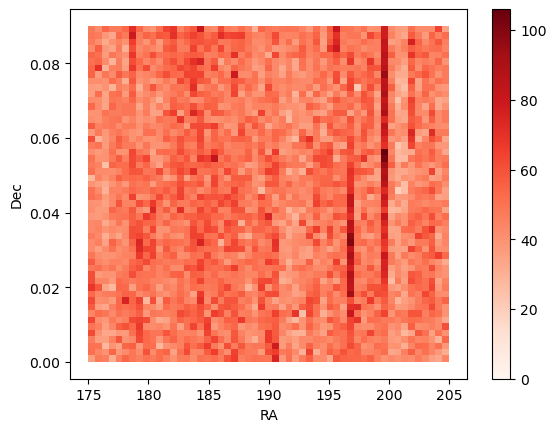

In [21]:
sns.histplot(x=ps1.raMean, y=ps1.decMean, cbar=True, cmap="Reds")

plt.xlabel("RA")
plt.ylabel("Dec")

plt.show()

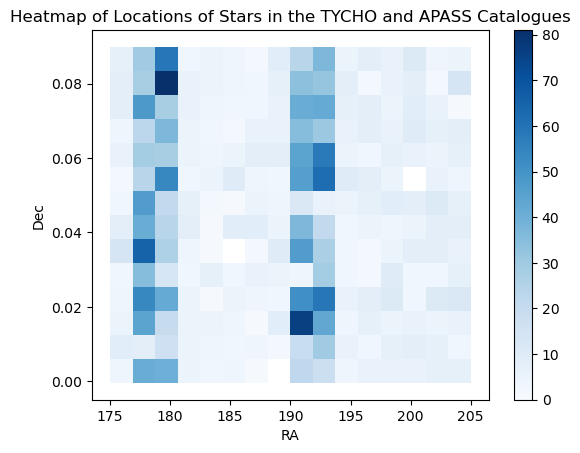

In [42]:
sns.histplot(x=bright_stars.RA, y=bright_stars.Dec, cbar=True, cmap="Blues")

plt.xlabel("RA")
plt.ylabel("Dec")

plt.title("Heatmap of Locations of Stars in the TYCHO and APASS Catalogues")

plt.show()

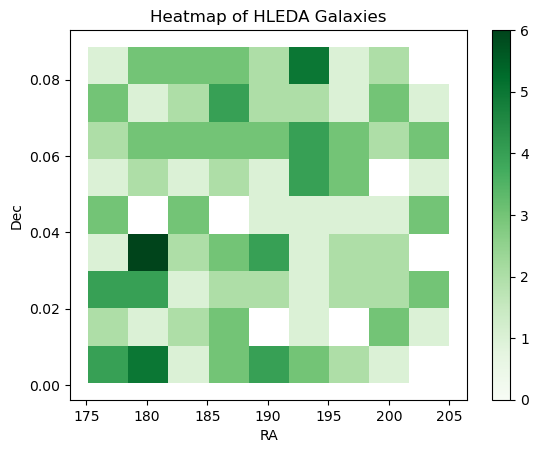

In [23]:
sns.histplot(x=resolved_gals.RA, y=resolved_gals.DEC, cbar=True, cmap="Greens")

plt.xlabel("RA")
plt.ylabel("Dec")

plt.title("Heatmap of HLEDA Galaxies")

plt.show()

In [24]:
cdes, zgrid, gal_info = rp.generate_redshift_predictions(ps1,
                                               bright_stars,
                                               resolved_gals,
                                               n_grid=1000,
                                               return_df=True)

100%|█████████████████████████████████████████| 169/169 [00:40<00:00,  4.22it/s]

Generating Predictions


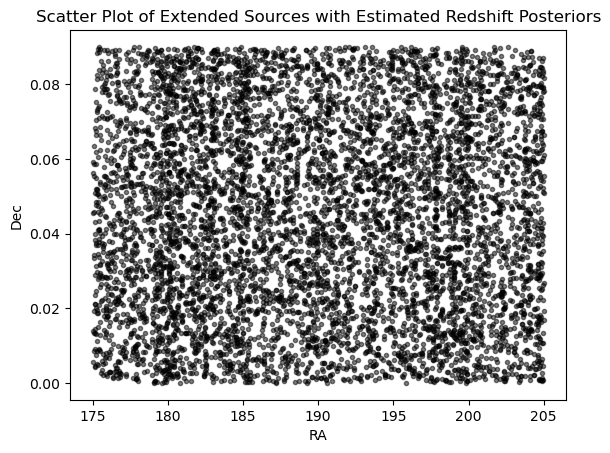

In [25]:
plt.plot(gal_info.raMean, gal_info.decMean, "k.", alpha=0.5)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("Scatter Plot of Extended Sources with Estimated Redshift Posteriors")
plt.show()

In [26]:
gal_info.columns

Index(['objID', 'raMean', 'decMean', 'gKronMag', 'gPSFMag', 'gKronMagErr',
       'gPSFMagErr', 'gExtNSigma', 'rKronMag', 'rPSFMag', 'rKronMagErr',
       'rPSFMagErr', 'rExtNSigma', 'iKronMag', 'iPSFMag', 'iKronMagErr',
       'iPSFMagErr', 'iExtNSigma', 'zKronMag', 'zPSFMag', 'zKronMagErr',
       'zPSFMagErr', 'zExtNSigma', 'yKronMag', 'yPSFMag', 'yKronMagErr',
       'yPSFMagErr', 'yExtNSigma', 'nDetections', 'gr_PS', 'ri_PS', 'iz_PS',
       'zy_PS', 'rMagNormPS', 'grNormPS', 'riNormPS', 'izNormPS', 'zyNormPS'],
      dtype='object')

In [27]:
mgc_zcat_roi.query("SDSS_PETMAG_R < 20 & SDSS_PETMAG_R > 17")

ID  MGCFN  ALPHA_J2000  DELTA_J2000  QUALITY  CLASS  INEXR  \
23675  23297     51    175.05206      0.06236        0      8      0   
23685  23367     51    175.01326      0.04989        0      8      0   
23693  23377     51    175.05988      0.04082        0      8      0   
23697  23381     51    175.04370      0.03892        0      8      0   
23698  23382     51    175.00941      0.03605        0      8      0   
...      ...    ...          ...          ...      ...    ...    ...   
50026  49463    111    204.97314      0.02633        2      1      0   
50036  49474    111    204.90851      0.08732        0      8      0   
50037  49477    111    204.96550      0.01318        0      8      0   
50040  49481    111    204.86784      0.08719        0      8      0   
50046  49488    111    204.87973      0.08643        1      1      0   

               SDSS_OBJID  SDSS_PSFMAG_G  SDSS_PSFMAG_R  SDSS_PSFMAG_I  \
23675  582093483814289452         17.424         17.111         17.059   
23685  582093483814289523         18.591         17.370         16.939   
23693  582093483814289549         19.753         19.442         19.375   
23697  582093483814289540         19.404         18.299         17.912   
23698  582093483814289521         19.514         18.098         17.511   
...                   ...            ...            ...            ...   
50026  582093483827396914         20.054         18.942         18.486   
50036  582093483827396828         19.210         17.853         16.993   
50037  582093483827396885         19.078         17.797         17.131   
50040  582093483827331258         19.415         19.052         18.938   
50046  582093483827396794         20.231         19.393         19.038   

       SDSS_PSFMAG_Z  SDSS_PETMAG_G  SDSS_PETMAG_R  SDSS_PETMAG_I  \
23675         17.014         17.424         17.140         17.013   
23685         16.693         18.568         17.397         16.936   
23693         19.192         19.846         19.538         19.432   
23697         17.657         19.402         18.358         17.920   
23698         17.139         19.574         18.162         17.530   
...              ...            ...            ...            ...   
50026         18.046         19.153         18.069         17.558   
50036         16.548         19.253         17.919         17.064   
50037         16.756         19.185         17.877         17.188   
50040         18.922         19.491         19.154         18.993   
50046         18.765         18.932         18.197         17.790   

       SDSS_PETMAG_Z   BEST_Z  BEST_ZQUAL  
23675         16.985  0.00025           4  
23685         16.702  9.99999           9  
23693         19.634  9.99999           9  
23697         17.652  9.99999           9  
23698         17.154  9.99999           9  
...              ...      ...         ...  
50026         17.273  0.14855           3  
50036         16.609  9.99999           9  
50037         16.837  9.99999           9  
50040         18.883  9.99999           9  
50046         17.571  0.21579           3  

[2482 rows x 18 columns]

### CrossMatching Galaxies Detected from Pipeline vs Respective Locations in MGC

In [28]:
gals_locs_from_pipeline = SkyCoord(ra=gal_info.raMean*u.deg, dec=gal_info.decMean*u.deg)
mgc_gal_locs = SkyCoord(ra=mgc_zcat_roi.ALPHA_J2000*u.deg, dec=mgc_zcat_roi.DELTA_J2000*u.deg)


In [29]:
idx, sep2d, dist3d = match_coordinates_sky(gals_locs_from_pipeline, mgc_gal_locs) #match results
match_df = pd.DataFrame(data={"ps1_index":idx, "sep2d_arcsecs":sep2d.arcsec ,"dist3d":dist3d })

In [30]:
match_df.query("sep2d_arcsecs > 5")

ps1_index  sep2d_arcsecs    dist3d
1          2442      91.566065  0.000444
3          2442      80.704325  0.000391
4          2618      50.017837  0.000242
7          2204      17.724416  0.000086
9          1506      83.719428  0.000406
...         ...            ...       ...
7069       4745      24.051686  0.000117
7070        517      59.315846  0.000288
7071       1320      55.740286  0.000270
7072       2132      30.003669  0.000145
7073       3893      32.388603  0.000157

[6421 rows x 3 columns]

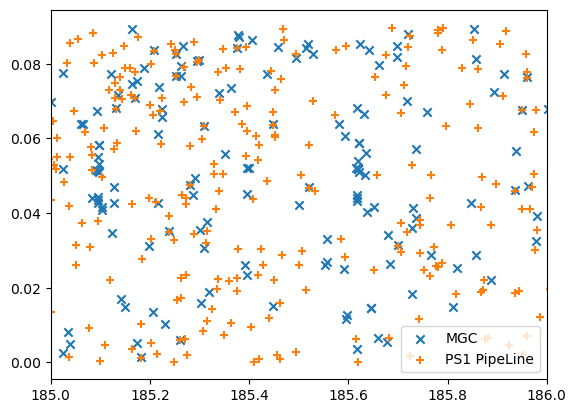

In [31]:
plt.scatter(mgc_gal_locs.ra.deg, mgc_gal_locs.dec.deg, marker="x", label="MGC")
plt.scatter(gals_locs_from_pipeline.ra.deg, gals_locs_from_pipeline.dec.deg, marker="+", label="PS1 PipeLine")

plt.xlim(185, 186)
# plt.ylim(0.04, 0.045)

plt.legend()
plt.show()

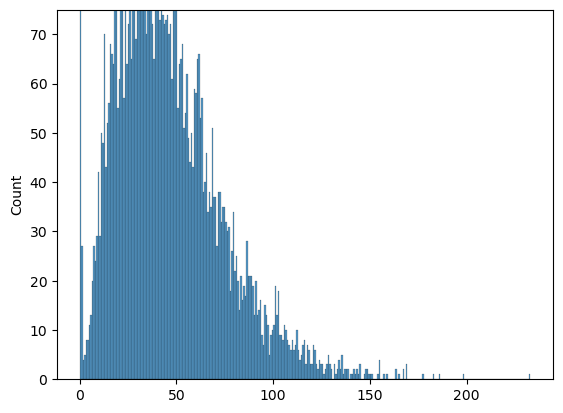

In [32]:
sns.histplot(sep2d.arcsec, bins=300)
# plt.xlim(0,40)
plt.ylim(0,75)

plt.show()

In [33]:
mgc_matches = mgc_zcat_roi.iloc[list(match_df.ps1_index)].reset_index(drop=True)

In [47]:
all_matched_gals_df = gal_info.join(mgc_matches)

In [48]:
all_matched_gals_df["sep2d_arcsec"] = match_df.sep2d_arcsecs

In [137]:
loc_of_best_z_estimate = [list(cde_vals).index(max(cde_vals)) for cde_vals in cdes]

z_pred = [zgrid[idx][0] for idx in loc_of_best_z_estimate]

In [138]:
all_matched_gals_df["z_pred"] = z_pred

In [139]:
all_matched_gals_df

objID      raMean   decMean   gKronMag    gPSFMag  \
0     108011811722216380  181.172157  0.013296  18.956699  19.660700   
1     108001898849609667  189.884921  0.007724  20.352200  21.493900   
2     108041812208986016  181.220805  0.037977  19.241800  20.166201   
3     108011898821412094  189.882118  0.009808  20.740200  21.282000   
4     108031912256622267  191.225642  0.026516  20.475000  21.371700   
...                  ...         ...       ...        ...        ...   
7069  108092044572643533  204.457246  0.077593  22.393700  23.394100   
7070  108101785647284788  178.564924  0.086973  21.728800  22.531700   
7071  108101830609627332  183.060962  0.089082  22.020700  23.044201   
7072  108101882192051293  188.219348  0.084068  22.137501  23.034800   
7073  108101996636895985  199.663690  0.087884  22.230200  23.379801   

      gKronMagErr  gPSFMagErr  gExtNSigma   rKronMag    rPSFMag  ...  \
0        0.007328    0.006118   15.959300  18.471399  19.331800  ...   
1        0.021642    0.024279   21.819099  19.550900  20.502001  ...   
2        0.011438    0.010158   18.592800  18.058701  18.977200  ...   
3        0.023684    0.020416   12.194500  20.193701  20.608299  ...   
4        0.029704    0.028441   15.430400  19.543501  20.334999  ...   
...           ...         ...         ...        ...        ...  ...   
7069     0.121444    0.147182    6.814330  21.919300  22.991800  ...   
7070     0.073855    0.077124    8.076690  21.680599  22.582001  ...   
7071     0.119002    0.152576    7.400040  21.823700  22.722900  ...   
7072     0.128470    0.141940    7.092340  21.675200  23.143801  ...   
7073     0.128486    0.156639    5.843320  21.751801  22.523500  ...   

      SDSS_PSFMAG_I  SDSS_PSFMAG_Z  SDSS_PETMAG_G  SDSS_PETMAG_R  \
0            18.717         18.550         18.753         18.302   
1            18.704         18.367         19.352         18.051   
2            18.137         17.749         19.440         18.015   
3            18.704         18.367         19.352         18.051   
4            15.897         15.858         16.431         16.086   
...             ...            ...            ...            ...   
7069         13.952         13.408         14.242         13.709   
7070         16.269         15.954         18.049         16.814   
7071          0.000          0.000          0.000          0.000   
7072         15.465         15.166         17.184         15.986   
7073         14.835         14.817         15.422         15.026   

      SDSS_PETMAG_I  SDSS_PETMAG_Z   BEST_Z  BEST_ZQUAL  sep2d_arcsec  \
0            18.028         18.074  0.02078           4      0.309640   
1            17.626         17.339  0.23525           4     91.566065   
2            17.420         17.201  0.20422           4      0.311058   
3            17.626         17.339  0.23525           4     80.704325   
4            15.954         15.915  9.99999           9     50.017837   
...             ...            ...      ...         ...           ...   
7069         13.559         13.425  9.99999           9     24.051686   
7070         16.337         16.088  0.00016           5     59.315846   
7071          0.000          0.000  9.99999           9     55.740286   
7072         15.480         15.203  9.99999           9     30.003669   
7073         14.892         14.887  9.99999           9     32.388603   

        z_pred  
0     0.178005  
1     0.271007  
2     0.082004  
3     0.292007  
4     0.289007  
...        ...  
7069  0.581012  
7070  0.113004  
7071  0.000002  
7072  0.114004  
7073  0.575012  

[7074 rows x 58 columns]

In [140]:
matched_gals_df = all_matched_gals_df.query("sep2d_arcsec < 2")

In [141]:
mgc_zcat_roi.query("SDSS_PETMAG_R < 20 & SDSS_PETMAG_R > 17")

ID  MGCFN  ALPHA_J2000  DELTA_J2000  QUALITY  CLASS  INEXR  \
23675  23297     51    175.05206      0.06236        0      8      0   
23685  23367     51    175.01326      0.04989        0      8      0   
23693  23377     51    175.05988      0.04082        0      8      0   
23697  23381     51    175.04370      0.03892        0      8      0   
23698  23382     51    175.00941      0.03605        0      8      0   
...      ...    ...          ...          ...      ...    ...    ...   
50026  49463    111    204.97314      0.02633        2      1      0   
50036  49474    111    204.90851      0.08732        0      8      0   
50037  49477    111    204.96550      0.01318        0      8      0   
50040  49481    111    204.86784      0.08719        0      8      0   
50046  49488    111    204.87973      0.08643        1      1      0   

               SDSS_OBJID  SDSS_PSFMAG_G  SDSS_PSFMAG_R  SDSS_PSFMAG_I  \
23675  582093483814289452         17.424         17.111         17.059   
23685  582093483814289523         18.591         17.370         16.939   
23693  582093483814289549         19.753         19.442         19.375   
23697  582093483814289540         19.404         18.299         17.912   
23698  582093483814289521         19.514         18.098         17.511   
...                   ...            ...            ...            ...   
50026  582093483827396914         20.054         18.942         18.486   
50036  582093483827396828         19.210         17.853         16.993   
50037  582093483827396885         19.078         17.797         17.131   
50040  582093483827331258         19.415         19.052         18.938   
50046  582093483827396794         20.231         19.393         19.038   

       SDSS_PSFMAG_Z  SDSS_PETMAG_G  SDSS_PETMAG_R  SDSS_PETMAG_I  \
23675         17.014         17.424         17.140         17.013   
23685         16.693         18.568         17.397         16.936   
23693         19.192         19.846         19.538         19.432   
23697         17.657         19.402         18.358         17.920   
23698         17.139         19.574         18.162         17.530   
...              ...            ...            ...            ...   
50026         18.046         19.153         18.069         17.558   
50036         16.548         19.253         17.919         17.064   
50037         16.756         19.185         17.877         17.188   
50040         18.922         19.491         19.154         18.993   
50046         18.765         18.932         18.197         17.790   

       SDSS_PETMAG_Z   BEST_Z  BEST_ZQUAL  
23675         16.985  0.00025           4  
23685         16.702  9.99999           9  
23693         19.634  9.99999           9  
23697         17.652  9.99999           9  
23698         17.154  9.99999           9  
...              ...      ...         ...  
50026         17.273  0.14855           3  
50036         16.609  9.99999           9  
50037         16.837  9.99999           9  
50040         18.883  9.99999           9  
50046         17.571  0.21579           3  

[2482 rows x 18 columns]

In [142]:
matched_gals_df = matched_gals_df.query("BEST_Z > 0 & BEST_Z < 8")

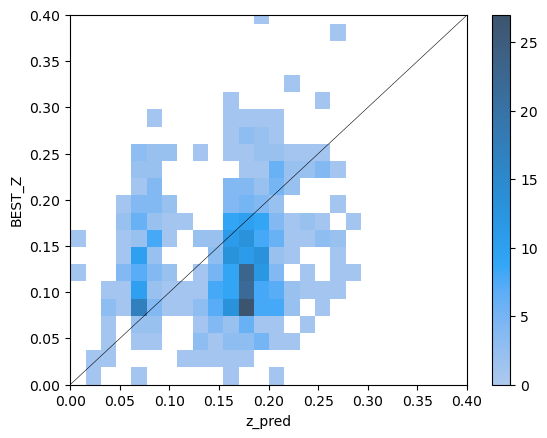

In [152]:
sns.histplot(x=matched_gals_df.z_pred, y=matched_gals_df.BEST_Z, cbar=True)
plt.plot([0,1],[0,1], "k-", linewidth=0.4)
plt.xlim(0,0.4)
plt.ylim(0,0.4)
plt.show()

In [11]:
zcat = mgc_zcat.query("SDSS_PETMAG_R < 20 & SDSS_PETMAG_R > 17")

<Axes: xlabel='BEST_Z', ylabel='Count'>

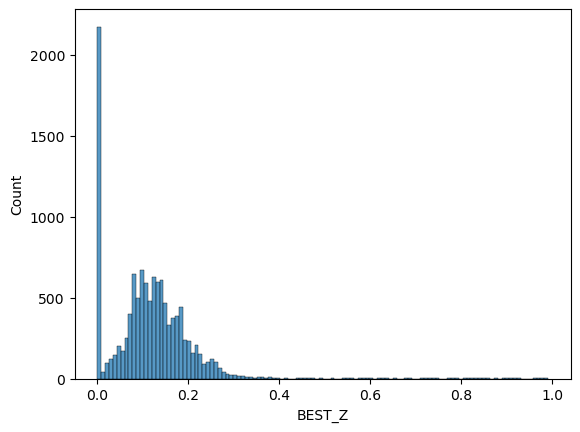

In [27]:
sns.histplot(zcat.query("BEST_Z < 1 & BEST_Z > 0").BEST_Z)

- is spike caused by default placeholder value?
- look at mgc flags